# Neural rendering optimization: Fit FLAME mesh for improved DECA results

Contents:


-    Pytorch 3D installation, FLAME and rendering examples;
-   Get image pairs, of face ground truth image and render prediction (DECA output);
-   Rendering and optimising/training FLAME for better single subject rendering (improving DECA results)



## Install all dependencies/requirements

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installations (Rest)
# After running this cell, restart runtime!

In [ ]:
!pip install chumpy
!pip install facenet_pytorch # for face detection
#!pip install rembg[gpu] #cannot use for now -requires python 3.9 version
'''
!pip install backgroundremover #for background removal
!pip uninstall -y Pillow
'''
# install the new one
!pip install Pillow
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.2 MB/s 
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58285 sha256=4b2868be268cabe0839c367be22617affbacb608ff171f1a63ad954792df4976
  Stored in directory: /root/.cache/pip/wheels/59/68/de/5e0c5d77e573e8c150e69e07a25035e6b6a04952d6e1814dbc
Successfully built chumpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Install Pytorch3D

In [ ]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

device = 'cuda'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0   876k      0 --:--:-- --:--:-- --:--:--  876k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-pqbe8r6h
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-pqbe8r6h
  Running command git checkout -q 276c9a8acbfa715f5802f26ec9f4141bde26ecb4
     |████████████████████████████████| 50 kB 2.8 MB/s 
     |████████████████████████████████| 42 kB 629 kB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.7.0-cp37-cp37m-linux_x86_64.whl size=30241275 sha256=a14ba4afb3be2a2285769595e34caceb711d5f03854ca7a7c433e10d7bc0101b
  Store

In [ ]:
%cd /content
import torch
import numpy as np
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes

from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras, 
    FoVPerspectiveCameras,
    PerspectiveCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader,
    TexturesAtlas,
    TexturesVertex,
    SoftPhongShader,
    SoftSilhouetteShader,
    BlendParams,
    TexturesVertex,
    TexturesUV
)

from pytorch3d.transforms import matrix_to_quaternion, quaternion_to_axis_angle, matrix_to_rotation_6d, axis_angle_to_matrix

/content


### Select device

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print("Device is", device)

Device is cuda


## Image (GT) and Render (Prediction) data

### Utility functions

In [ ]:
from PIL import Image
import numpy as np
import cv2
import torch
from torchvision import transforms
from facenet_pytorch import MTCNN as mtcnn

def pad(img, new_size, old_size, color=[255, 255, 255]):
  padded_img = np.full((new_size,new_size, 3), fill_value=tuple(color))

  # compute center offset - same for square images
  x_center = int((new_size - old_size) // 2)
  y_center = int((new_size - old_size) // 2)

  # copy img image into center of result image
  padded_img[y_center:y_center+ old_size, 
        x_center:x_center+old_size] = img
  return padded_img

def remove_background_old(img="", img_path="", color=""):
  ''' Remove background from image array or imgage path
      img: image 0-255, uint8, rgb, [h, w, 3]
      img_path: path to image
      return: detected box
  '''
  try:
    #img = np.uint8(img)
    cropped_img = Image.fromarray(img)
  except:
    print("Img array was not loaded")
    cropped_img = Image.open(img_path)
    
  temp_path = "/content/sample_data/temp.jpg"
  temp2_path = "/content/sample_data/temp2.jpg"
  cropped_img.save(temp_path)
  !backgroundremover -i $temp_path -o $temp2_path
  img = np.asarray(Image.open(temp2_path).convert('RGB'))
  return img



def remove_background(img="", img_path="", color=""):
  ''' Remove background from image array or imgage path
      img: image 0-255, uint8, rgb, [h, w, 3]
      img_path: path to image
      return: detected box
  '''
  return img
  

def crop_img(img_path="", img=""):
  ''' Detect face and crop image
      img_path: path to image
      return: detected box
  '''
  try:
    temp_img = img.copy()
    img = img.copy()
  except:
    temp_img = np.asarray(Image.open(img_path).convert('RGB'))
    img = np.asarray(Image.open(img_path).convert('RGB'))
  face_detector = mtcnn(keep_all=True)
  out = face_detector.detect(temp_img)
  if out[0] is None:
    print("No face is detected")
    return img
  else:
    bbox = out[0][0].squeeze().astype(int)
    y1 = bbox[0]
    y2 = bbox[2]
    x1 = bbox[1]
    x2 = bbox[3]
    dx = int((x2-x1)/4) # use this to catch the shoulders
    dy = int((y2-y1)/4) # and neck and hair
    cropped_img = img.copy()[abs(x1-dx):abs(x2+dx), abs(y1-dy):abs(y2+dy)]
    return cropped_img

def img_to_tensor(img_path):
  ''' img should be a float value [0,1] '''
  img = np.asarray(Image.open(img_path).convert('RGB'))
  img = img / 255 #normalized like the render
  tensor = torch.Tensor(img).unsqueeze(0)
  return tensor


In [ ]:
def load_img(img_path, cropped=True, img_size=256,
             background_remove=False, scale=1, pad_color=[255,255,255],
             render_size=200, replace=False, preprocessing=True):
    ''' Load an image as a torch sensor. This is used to preprocess gt images 
        for mesh fitting
        img_path: path to image (str)
        cropped: crop image/face detection (boolean)
        img_size: maximum h and w of image (int)
        background_remove: remove background/replace with transparent background(boolean)
        scale: zoom in/zoom out effect of face in image frame (float: [0-1])
        pad_color: RGB channel for image padding (int array: (3,1))
        render_size: this should match the render size and corresponds to the size of the face in the image frame (int)
    '''
    if not preprocessing:
      return img_to_tensor(img_path)

    if cropped:
      img = crop_img(img_path)
    else:
      img = np.asarray(Image.open(img_path).convert('RGB'))
    h, w, _ = img.shape
    max_dim = max(h, w)

    if background_remove:
      img = remove_background(img)
      img [(img == 1)] = 255
      img [(img == 0)] = 255

    try:
      scaled_size = int((scale) * img_size) # face imgs of only squares
      img = cv2.resize(img, (scaled_size, scaled_size), interpolation=cv2.INTER_AREA)
    except:
      print("Scale value needs to be a float value between (0-1]")



    
    img = pad(img, new_size=img_size, old_size=scaled_size, color=pad_color)

    
    img = img / 255 #normalized like the render
    if replace:
      plt.imsave(img_path, img)
    tensor = torch.Tensor(img).unsqueeze(0)
    #tensor = tensor.to(torch.float32)
          
    return tensor

In [ ]:
# Extract background through RVM 
import torch
!pip install av tqdm pims
model = torch.hub.load("PeterL1n/RobustVideoMatting", "mobilenetv3").cuda() # or "resnet50"
convert_video = torch.hub.load("PeterL1n/RobustVideoMatting", "converter")
def extract_background(png_sequence_path, output_path, progress=False, alpha_pred_path="",
                       foreground_pred_path="", output_type="png_sequence"):
  ''' Remove background technique through RVM for image sequence '''
  convert_video(
      model,                           # The loaded model, can be on any device (cpu or cuda).
      input_source=png_sequence_path,        # A video file or an image sequence directory.
      downsample_ratio=None,           # [Optional] If None, make downsampled max size be 512px.
      output_type=output_type,             # Choose "video" or "png_sequence"
      output_composition=output_path,    # File path if video; directory path if png sequence.
      #output_alpha=alpha_pred_path,          # [Optional] Output the raw alpha prediction.
      #output_foreground=foreground_pred_path,     # [Optional] Output the raw foreground prediction.
      #output_video_mbps=4,             # Output video mbps. Not needed for png sequence.
      seq_chunk=12,                    # Process n frames at once for better parallelism.
      num_workers=1,                   # Only for image sequence input. Reader threads.
      progress=progress                # Print conversion progress.
  )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.2 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
  Created wheel for pims: filename=PIMS-0.6.1-py3-none-any.whl size=82636 sha256=330464b08bae5b6f197bb9acabefc80210b83de0443a6f2d4031c891f64ae837
  Stored in directory: /root/.cache/pip/wheels/8e/d5/a9/f702433436655b7a2bc7ff93efd742587dd5abd44f7e406917
Successfully built pims


/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/PeterL1n/RobustVideoMatting/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/PeterL1n/RobustVideoMatting/releases/download/v1.0.0/rvm_mobilenetv3.pth" to /root/.cache/torch/hub/checkpoints/rvm_mob

  0%|          | 0.00/14.5M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/PeterL1n_RobustVideoMatting_master


### Dataset

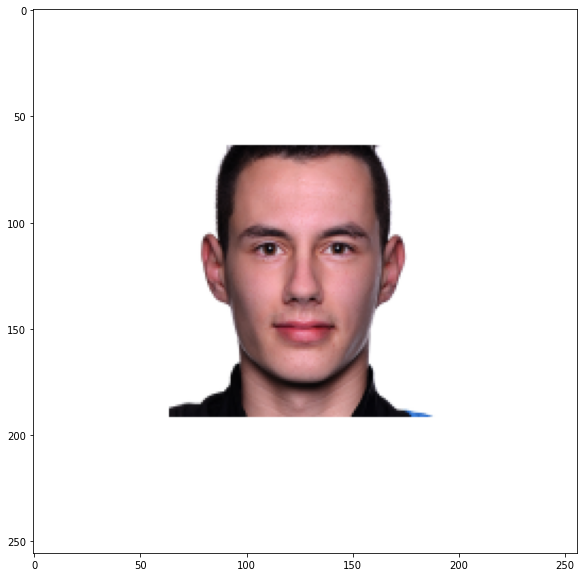

In [ ]:
#example image
path = "/content/drive/MyDrive/datasets/custom_test/test1.png" #change line with path to image
img = load_img(path, background_remove=False, cropped=False, replace=False, scale=0.5, preprocessing=True)
img = img.squeeze(0).detach().cpu().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(img)

##  Define and render an example mesh

### Define Camera View

In [ ]:
# Define camera matrix C
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    FoVPerspectiveCameras
)
device = torch.device("cuda:0")
R, T = look_at_view_transform(dist=0.8, elev=0, azim=0) # 0 elevation , and 0 azimuth
C = FoVPerspectiveCameras(device=device, R=R, T=T)

### Define Phong renderer

In [ ]:
# define renderer

from pytorch3d.renderer import  (MeshRenderer, MeshRasterizer, SoftPhongShader,
    PointLights, Materials, RasterizationSettings,BlendParams
)

def get_phong_renderer(C_init, 
                      sigma=1.0e-4, 
                      gamma=1.0e-7, 
                      faces_per_pixel=50,
                      img_size=256,
                       blur_radius=1, background_path="", device=device):
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

  materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0)
  
  try:
    background_color = Image.open(background_path)/ 255
    #background_color = [H, W, 3] # from (0-1)
  except:
    background_color = (1,1,1)
  
  blend_params = BlendParams(background_color=background_color, sigma=sigma, gamma=gamma)

  
  #blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=background/255)
  if blur_radius is not 0:
      blur_radius= np.log(1. / 1e-4 - 1.) * blend_params.sigma
  else: blur_radius = 0

  raster_settings = RasterizationSettings(
      image_size=img_size, 
      blur_radius= blur_radius, 
      faces_per_pixel=faces_per_pixel, 
  )

  r = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=C_init,
          raster_settings=raster_settings
      ),
      shader=SoftPhongShader(
          device=device, 
          blend_params = blend_params,
          cameras=C_init,
          materials=materials,
          lights=lights
      )
  )

  return r

### Define Shilouette renderer



In [ ]:
def get_silhoutte_renderer(C_init, 
                      sigma=1.0e-7, 
                      gamma=1.0e-1, 
                      faces_per_pixel=50,
                      img_size=256, 
                      blur_radius=1, device=device):
  
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

  materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0)
  
  blend_params = BlendParams(background_color=(1,1,1), sigma=sigma, gamma=gamma)
  if blur_radius is not 0:
    blur_radius= np.log(1. / 1e-4 - 1.) * blend_params.sigma
  else: blur_radius = 0

  raster_settings = RasterizationSettings(
      image_size=img_size, 
      blur_radius=blur_radius, 
      faces_per_pixel=faces_per_pixel, 
  )

  r = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=C_init, 
          raster_settings=raster_settings
      ),
      shader=SoftSilhouetteShader(blend_params=blend_params)
  )

  return r

### Render Example from saved (.obj) file

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:529: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


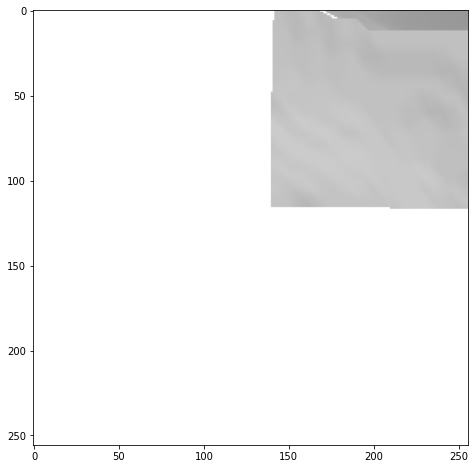

In [ ]:
#@title Display example render via phong renderer
obj_filename = '/content/drive/MyDrive/datasets/custom_test/test1.obj' #change line
device = torch.device("cuda:0")
verts, faces_idx, _ = load_obj(obj_filename, device=device)
faces = faces_idx.verts_idx.to(device)
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
# N is the batch size
# V is the number of vertices
# F is the number of faces
textures = TexturesVertex(verts_rgb) #verts_features: list of (Vi, C) or (N, V, C) tensor giving a feature vector
# C = 3-dimensional vector              


mesh = Meshes(
verts=[verts.to(device)],
faces=[faces.to(device)],
textures=textures
)

renderer = get_phong_renderer(C, sigma=1.0e-6, gamma=1.0e-7, faces_per_pixel=1, blur_radius=0) # this returns a MeshRenderer object
I = renderer(mesh.to(device)).detach().cpu().numpy()


plt.figure(figsize=(8, 8))
plt.imshow(I[0, :, :, 0:3])

## Get Image Pairs

### Utility Functions

In [ ]:
# auxiliary function: get render and ground truth images
from pytorch3d.transforms import axis_angle_to_matrix
from pytorch3d.structures import Meshes

# random initialization for some
def get_image_pair(prediction_path, data_path, frame_num, renderer,
                   name="", scale=0.3, silh=False, skip_gt=False, opt=True,
                   background_remove=False, cropped=False, preprocessing=True, 
                   format=".png"):
  device = torch.device("cuda:0")
  img_size = config.uv_size
  frame_path =  name + '_frame%04d' % frame_num
  img_gt_path = os.path.join(data_path, '%04d' % frame_num +format)
  
  if not skip_gt:
    try:
      I_gt = load_img(img_path=img_gt_path, background_remove=background_remove,
                      preprocessing=preprocessing, scale=scale, img_size=img_size, cropped=cropped).to(device)
    except:
      print("Could not load ground truth image", img_gt_path)
  else:
     I_gt = np.zeros((img_size, img_size, 3))

  if opt:
    params = {"shape": shape, "exp": exp, "tex": tex, "pose": pose, "uv_map": uvtexture} # get updated flame parameters from optimization
    flame_path=""
    texture_path = ""
  else:
    texture_path = os.path.join(os.path.join(prediction_path, frame_path ),frame_path+".png") # get texture map from DECA output results
    params = None
    flame_path = os.path.join(os.path.join(prediction_path, frame_path ), "flame_params.pkl") # get output DECA params

  I_pred = get_render(params=params, param_path=flame_path, renderer=renderer, texture_path=texture_path) #flame_model=flame_model,tex_flame_model=tex_flame_model)  # pass it to the pytorch render
  if silh:
    I_gt = I_gt[:, :, :, 2]
    I_gt[I_gt > 0.7] = 0
    I_gt[I_gt !=0] = 1
    I_pred = I_pred[:, :, :, 3]
  else:
    I_pred = I_pred[:, :, :, 0:3]
    
  return I_pred, I_gt

### Save GT images (after background removal -  Time efficient)

In [ ]:
data_path = "/content/sample_dataset/00003"
gt_path = "/content/sample_dataset/gt/"

os.makedirs(gt_path, exist_ok=True)
# rename to .png format before removing background
for frame in os.listdir(data_path):
  if ".jpg" in frame:
    path = os.path.join(data_path, frame)
    new_path = path.replace(".jpg", ".png")
    os.rename(path, new_path)
    #img = load_img(path, background_remove=False, replace=False, cropped=False, scale=1)
    #img = img.squeeze(0).detach().cpu().numpy()
    #plt.imsave(os.path.join(gt_path, frame.split(".")[0] + ".png"), img)

# remove background for small dataset folder (png sequence)
extract_background(png_sequence_path=data_path, output_path=gt_path, progress=True)


  0%|          | 0/225 [00:00<?, ?it/s]

### Display training image pairs e.g GT & Prediction

In [ ]:
# auxiliary function: get render and ground truth images
from pytorch3d.transforms import axis_angle_to_matrix
from pytorch3d.structures import Meshes

# random initialization for some
def get_image_pair(prediction_path, data_path, frame_num, renderer,
                   name="", scale=0.3, silh=False, skip_gt=False, opt=True,
                   background_remove=False, cropped=False, preprocessing=True, 
                   format=".png"):
  device = torch.device("cuda:0")
  img_size = config.uv_size
  frame_path =  name + '_frame%04d' % frame_num
  img_gt_path = os.path.join(data_path, '%04d' % frame_num +format)
  
  if not skip_gt:
    try:
      I_gt = load_img(img_path=img_gt_path, background_remove=background_remove,
                      preprocessing=preprocessing, scale=scale, img_size=img_size, cropped=cropped).to(device)
    except:
      print("Could not load ground truth image", img_gt_path)
  else:
     I_gt = np.zeros((img_size, img_size, 3))

  if opt:
    params = {"shape": shape, "exp": exp, "tex": tex, "pose": pose, "uv_map": uvtexture} # get updated flame parameters from optimization
    flame_path=""
    texture_path = ""
  else:
    texture_path = os.path.join(os.path.join(prediction_path, frame_path ),frame_path+".png") # get texture map from DECA output results
    params = None
    flame_path = os.path.join(os.path.join(prediction_path, frame_path ), "flame_params.pkl") # get output DECA params

  I_pred = get_render(params=params, param_path=flame_path, renderer=renderer, texture_path=texture_path) #flame_model=flame_model,tex_flame_model=tex_flame_model)  # pass it to the pytorch render
  if silh:
    I_gt = I_gt[:, :, :, 2]
    I_gt[I_gt > 0.7] = 0
    I_gt[I_gt !=0] = 1
    I_pred = I_pred[:, :, :, 3]
  else:
    I_pred = I_pred[:, :, :, 0:3]
    
  return I_pred, I_gt

creating the FLAME Decoder


/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:534: UserWarning: Mtl file does not exist: /content/FLAME/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


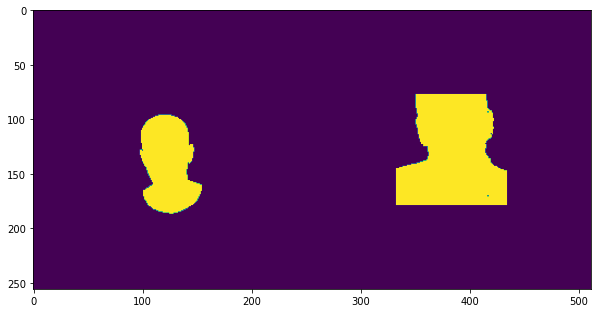

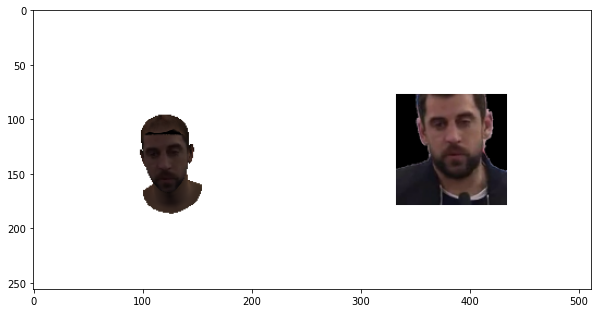

In [ ]:
# @title Image - Render pair
R, T = look_at_view_transform(dist=0.8, elev=0.0, azim=0) # 0 elevation , and 0 azimuth

C = FoVPerspectiveCameras(device=device, R=R, T=T)
renderer_phong = get_phong_renderer(C, sigma=1.0e-7, gamma=1.0e-7, 
                                    faces_per_pixel=1, img_size=256)
renderer_sil = get_silhoutte_renderer(C, sigma=1.0e-7, gamma=1.0e-7, 
                                    faces_per_pixel=1, img_size=256)



target_image = path
name = str(target_image.split("/")[-1])

# Silhouette render
I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=gt_path,
                              frame_num=frame_num, renderer=renderer_sil,
                              name=name,
                              background_remove= False, cropped=False, format=".png",
                              silh=True, scale = 0.4, opt=False)
I_pred_sil = I_pred[:,:,:]
I_pred_sil[I_pred_sil!=0] = 1
I_merged = torch.cat([ I_pred_sil, I_gt], 2)[0].detach().cpu()
plt.figure(figsize=(10, 20))
plt.imshow(I_merged) #matplot displays background color as black


# Textured render
I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=gt_path,
                              frame_num=frame_num, renderer=renderer_phong,
                              name=name,
                              #flame_model=flame_model, tex_flame_model=tex_flame_model,
                              background_remove= False, cropped=False, format=".png",
                              silh=False, scale = 0.4, opt=False)

I_merged = torch.cat([ I_pred, I_gt], 2)[0].detach().cpu()
plt.figure(figsize=(10, 20))
plt.imshow(I_merged) #matplot displays background color as black

## Optimization of mesh

In [ ]:
### General parameters
max_frame = 40 # number of available training frames
img_size = 256 # image dimension of each training frame - SHOULD MATCH render (image) dimension
n_epochs = 30
target_path  = '/content/drive/MyDrive/datasets/custom_test/test1.png' #path to folder with DECA predictions
obj_filename = '/content/drive/MyDrive/datasets/custom_test/test1.obj' #change line


### Define phong renderer
dist = 1.0 #initial camera distance
elev = 0.0 # initial elevation
azim = 0.0 # initial azimuth (think of it as yaw)
R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim) # 0 elevation , and 0 azimuth
C = FoVPerspectiveCameras(device=device, R=R, T=T)
renderer_sil = get_silhoutte_renderer(C, sigma=1.0e-7, gamma=1.0e-7, 
                                    faces_per_pixel=50, img_size=img_size)

### Initialize Camera distance
cam_distance = torch.nn.Parameter(torch.tensor([dist]), requires_grad=True)
elevation =  torch.nn.Parameter(torch.tensor([elev]), requires_grad=True)
azimuth =  torch.nn.Parameter(torch.tensor([azim]), requires_grad=True)



### Initialize Texture optimization parameters
texture_rgb = torch.ones_like(verts)[None] # (1, V, 3)
tex = torch.nn.Parameter(texture_rgb , requires_grad=True)


### Optimizers

tex_opt = torch.optim.Adam([tex], lr=2.0e-3) # texture optimization via tex code
cam_opt = torch.optim.Adam([azimuth, elevation, cam_distance], lr=2.0e-2) # camera optimization
cam_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cam_opt, patience=3,
                                                           verbose=True)
crit = torch.nn.L1Loss() # L1 loss for optimization

### Silhouette/Shape Optimization

In [ ]:
sil_log_dir = '/content/logs_sil_optimization'
!rm -rf $sil_log_dir
!mkdir $sil_log_dir

#data_path = "/content/sample_dataset/gt" # if you want to remove the background just use this path and specify the ".png" format
format = ".png"
for epoch_id in range(0, n_epochs):
  scale = 0.4
  I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=gt_path,
                              frame_num=frame_num, renderer=renderer_sil, name=name, format=format,
                               silh=True, scale=scale, background_remove=False, cropped=False)
  I_pred_sil = I_pred[:,:,:]
  I_pred_sil[I_pred_sil!=0] = 1
  I_merged = torch.cat([I_pred_sil, I_gt], 2)[0].detach().cpu().clip(0, 1).numpy()
  plt.imsave(os.path.join(sil_log_dir, '%04d.png' % epoch_id), I_merged)

  #train_frames = np.random.randint(low=0, high=max_frame, size=(10))#max_frame)) # train on random frames
  train_frames = np.ones((1,1)) * 1 # train on same frame
  #train_frames = np.arange(0, max_frame, 1, dtype=int)

  total_loss = 0 # initial loss is 0 

  R, T = look_at_view_transform(dist=cam_distance, elev=elevation, azim=azimuth) # 0 elevation , and 0 azimuth
  C = FoVPerspectiveCameras(device=device, R=R, T=T)
  renderer_sil = get_silhoutte_renderer(C, sigma=1.0e-7, gamma=1.0e-7, 
                                  faces_per_pixel=50, img_size=img_size, device=device)

  I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=gt_path,format=format,
                            frame_num=frame_num, renderer=renderer_sil, name=name, scale=scale,
                            silh=True, background_remove=False,  cropped=False)
  
  

  loss = crit(I_gt.to(device), I_pred.to(device))
  total_loss += float(loss)
  cam_opt.zero_grad()
  loss.backward()
  cam_opt.step()

  print("e", str(epoch_id),"- Total L1 loss: %f" %total_loss)
  cam_scheduler.step(total_loss)


/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:534: UserWarning: Mtl file does not exist: /content/FLAME/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


e 0 - Total L1 loss: 0.084235
e 1 - Total L1 loss: 0.082427
e 2 - Total L1 loss: 0.080506
e 3 - Total L1 loss: 0.078580
e 4 - Total L1 loss: 0.076505
e 5 - Total L1 loss: 0.074919
e 6 - Total L1 loss: 0.073707
e 7 - Total L1 loss: 0.072494
e 8 - Total L1 loss: 0.071310
e 9 - Total L1 loss: 0.070022
e 10 - Total L1 loss: 0.068973
e 11 - Total L1 loss: 0.067906
e 12 - Total L1 loss: 0.066743
e 13 - Total L1 loss: 0.065761
e 14 - Total L1 loss: 0.064540
e 15 - Total L1 loss: 0.063524
e 16 - Total L1 loss: 0.062546
e 17 - Total L1 loss: 0.061987
e 18 - Total L1 loss: 0.061919
e 19 - Total L1 loss: 0.062145
e 20 - Total L1 loss: 0.062589
e 21 - Total L1 loss: 0.063045
e 22 - Total L1 loss: 0.063206
e 23 - Total L1 loss: 0.063171
e 24 - Total L1 loss: 0.062612
Epoch 00025: reducing learning rate of group 0 to 2.0000e-03.
e 25 - Total L1 loss: 0.062114
e 26 - Total L1 loss: 0.062133
e 27 - Total L1 loss: 0.062334
e 28 - Total L1 loss: 0.062297
e 29 - Total L1 loss: 0.062293


In [ ]:
# @title generate silhouette optimisation video
out_video = "/content/silhouette_optimisation.mp4" #path to output video
%cd /content/logs_sil_optimization
!ffmpeg -framerate 1 -pattern_type glob -i '*.png' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  {out_video}
%cd /content

/content/logs_sil_optimization
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxm

In [ ]:
# @title Show silhouette optimisation process
from IPython.display import HTML
from base64 import b64encode
mp4 = open(out_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Texture Optimization

In [ ]:
rgb_log_dir = '/content/logs_phong_optimization'
!rm -rf $rgb_log_dir
!mkdir $rgb_log_dir


# use renderer with optimized camera parameters
R, T = look_at_view_transform(dist=cam_distance.item(), elev=elevation.item(), azim=azimuth.item()) 
C = FoVPerspectiveCameras(device=device, R=R, T=T)
renderer_phong = get_phong_renderer(C, sigma=1.0e-7, gamma=1.0e-7, 
                                    faces_per_pixel=1, img_size=img_size)


for epoch_id in range(0, n_epochs):
  I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=gt_path,
                              frame_num=frame_num, renderer=renderer_phong,
                              #flame_model=flame_model, tex_flame_model=tex_flame_model,
                              name=name, silh=False, scale=scale, background_remove=False, cropped=False)
  I_merged = torch.cat([I_pred, I_gt], 2)[0].detach().cpu().clip(0, 1).numpy()
  plt.imsave(os.path.join(rgb_log_dir, '%04d.png' % epoch_id), I_merged)

  train_frames = np.random.randint(low=0, high=max_frame, size=(10))#max_frame)) # train on random frames
  #train_frames = np.ones((1,1)) * 5 # train on same frame

  total_loss = 0 # initial loss is 0 

  for frame_num in train_frames:

    I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=gt_path,
                              frame_num=frame_num, renderer=renderer_phong, scale=scale,
                              name=name, silh=False, background_remove=False, cropped=False)

    loss = crit(I_gt.to(device), I_pred.to(device))
    #loss.requires_grad = True
    total_loss += float(loss)

    uv_opt.zero_grad()
    #face_opt.zero_grad()
    loss.backward()

    uv_opt.step()
    #face_opt.step()

  print("e", str(epoch_id),"- Total L1 loss: %f" %total_loss)
  #face_scheduler.step(total_loss)
  uv_scheduler.step(total_loss)


/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:534: UserWarning: Mtl file does not exist: /content/FLAME/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


e 0 - Total L1 loss: 0.792478
e 1 - Total L1 loss: 0.790795
e 2 - Total L1 loss: 0.788829
e 3 - Total L1 loss: 0.784958
e 4 - Total L1 loss: 0.781949
e 5 - Total L1 loss: 0.777960
e 6 - Total L1 loss: 0.776654
e 7 - Total L1 loss: 0.773699
e 8 - Total L1 loss: 0.776929
e 9 - Total L1 loss: 0.769463
e 10 - Total L1 loss: 0.769850
e 11 - Total L1 loss: 0.761543
e 12 - Total L1 loss: 0.762810
e 13 - Total L1 loss: 0.762299
e 14 - Total L1 loss: 0.760234
e 15 - Total L1 loss: 0.756368
e 16 - Total L1 loss: 0.758383
e 17 - Total L1 loss: 0.753410
e 18 - Total L1 loss: 0.753063
e 19 - Total L1 loss: 0.751041
e 20 - Total L1 loss: 0.746505
e 21 - Total L1 loss: 0.742668
e 22 - Total L1 loss: 0.744443
e 23 - Total L1 loss: 0.738895
e 24 - Total L1 loss: 0.736052
e 25 - Total L1 loss: 0.736864
e 26 - Total L1 loss: 0.734064
e 27 - Total L1 loss: 0.733272
e 28 - Total L1 loss: 0.729959
e 29 - Total L1 loss: 0.725120


In [ ]:
# @title generate texture optimisation video
out_video = "/content/texture_optimization.mp4" #path to output video
%cd /content/logs_phong_optimization
!ffmpeg -framerate 1 -pattern_type glob -i '*.png' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  /content/texture_optimization.mp4
%cd /content

/content/logs_phong_optimization
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-lib

In [ ]:
# @title Show texture optimisation process
from IPython.display import HTML
from base64 import b64encode
mp4 = open(out_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)